In [558]:

import numpy as np

from benchmarl.environments.common import Task, TaskClass

from benchmarl.utils import DEVICE_TYPING

from gymnasium import spaces
from pettingzoo import ParallelEnv
import numpy as np
import random
import gymnasium as gym
from gymnasium import spaces
from pettingzoo import ParallelEnv
import matplotlib.pyplot as plt
from torchrl.data import CompositeSpec
from torchrl.envs import EnvBase, PettingZooWrapper
import torch


In [559]:
class MyCustomEnv2(ParallelEnv):
    """Custom GridWorld environment following PettingZoo Parallel interface with multiple moving agents"""
    metadata = {'render.modes': ['human'], "name": "gridworld_parallel_v0"}

    def __init__(self, size=(10, 10), target=(0, 0), obstacles=None, num_moving_agents=50):
        super().__init__()
        self.size = size
        self.target = target
        obstacles_test = [(x, y) for x in range(1, 9) for y in range(1, 9)]
        self.obstacles = obstacles_test if obstacles_test else []
        self.num_moving_agents = num_moving_agents

        # Define agents
        self.agents = [f"movement_agent_{i}" for i in range(num_moving_agents)]
        self.possible_agents = self.agents[:]

        # Action spaces: discrete for movement agents
        self.action_spaces = {
            agent: spaces.Discrete(5) for agent in self.agents
        }

        # Observation spaces: position + flattened mean field
        grid_area = size[0] * size[1]
        movement_obs_size = 2 + grid_area
        self.observation_spaces = {
            agent: spaces.Box(low=0, high=1, shape=(movement_obs_size,), dtype=np.float32)
            for agent in self.agents
        }

        # Movement directions: Left, Right, Stay, Up, Down
        self.actions = [(-1, 0), (1, 0), (0, 0), (0, 1), (0, -1)]

        # State variables
        self.positions = []
        self.mean_field = np.zeros(self.size, dtype=np.float32)
        self.steps = 0
        self.max_steps = 100
        self.congestion_coefficient = 1

    def reset(self, seed=42, options=None):
        random.seed(seed)
        self.agents = self.possible_agents[:]
        self.positions = []
        for _ in range(self.num_moving_agents):
            x = int(9 )
            y = int(9 )
            self.positions.append((x, y))
        self.steps = 0
        self.rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self._update_mean_field()
        return self._get_obs(), self._get_info()

    def _update_mean_field(self):
        mean_field = np.zeros(self.size, dtype=np.float32)
        for x, y in self.positions:
            mean_field[x, y] += 1
        self.mean_field = mean_field / max(self.num_moving_agents, 1)

    def is_valid_position(self, pos):
        x, y = pos
        return (0 <= x < self.size[0] and
                0 <= y < self.size[1] and
                pos not in self.obstacles)

    def step(self, actions):
        """Execute a step for all agents in parallel"""
        rewards = {}
        new_positions = self.positions.copy()

        for agent, action in actions.items():
            agent_idx = int(agent.split("_")[2])
            pos = self.positions[agent_idx]

            if pos == self.target:
                rewards[agent] = 0
                continue

            dx, dy = self.actions[action]
            new_pos = (pos[0] + dx, pos[1] + dy)

            if self.is_valid_position(new_pos):
                new_positions[agent_idx] = new_pos

            # Reward: bonus for reaching target, penalty for time + congestion
            time_cost = 0.5
            x, y = new_positions[agent_idx]
            congestion_cost = self.mean_field[x, y] if self.is_valid_position(new_pos) else 10
            target_bonus = 15 if new_positions[agent_idx] == self.target else 0

            rewards[agent] = target_bonus - (time_cost + self.congestion_coefficient * congestion_cost)

        self.positions = new_positions
        self._update_mean_field()
        self.steps += 1

        # Check termination
        terminated = all(pos == self.target for pos in self.positions)
        truncated = self.steps >= self.max_steps
        self.terminations = {agent: terminated for agent in self.agents}
        self.truncations = {agent: truncated for agent in self.agents}

        self.rewards = rewards
        return self._get_obs(), rewards, self.terminations, self.truncations, self._get_info()

    def _get_obs(self):
        obs = {}
        flat_mean_field = self.mean_field.copy().flatten()
        for agent_idx, agent in enumerate(self.agents):
            position = np.array(self.positions[agent_idx], dtype=np.float32)
            position[0] /= self.size[0]
            position[1] /= self.size[1]
            
            # -----------------------------------------------------------------
            # THE FIX: Force a deep copy of the final observation array
            # -----------------------------------------------------------------
            obs[agent] = np.concatenate([position, flat_mean_field])
            
        return obs

    def _get_info(self):
        return {agent: {} for agent in self.agents}

    def render(self, mode="human"):
        grid_size = self.size[0]

        if not hasattr(self, "fig") or self.fig is None:
            plt.ion()
            self.fig, self.ax = plt.subplots(figsize=(6, 6))
            self.colorbar = None

        self.ax.clear()
        density = self.mean_field.copy()
        masked_density = np.ma.array(density, mask=False)
        for ox, oy in self.obstacles:
            masked_density[ox, oy] = np.nan

        cmap = plt.cm.Reds
        cmap.set_bad(color="black")

        im = self.ax.imshow(masked_density, origin="upper", cmap=cmap, interpolation="nearest")

        # Mark target
        self.ax.scatter(
            self.target[1],
            self.target[0],
            marker="s",
            c="lime",
            edgecolor="black",
            s=200,
            label="Target"
        )

        self.ax.set_xticks(np.arange(-0.5, grid_size, 1))
        self.ax.set_yticks(np.arange(-0.5, grid_size, 1))
        self.ax.set_xticklabels([])
        self.ax.set_yticklabels([])
        self.ax.grid(True, which="both", color="black", linewidth=0.5)
        self.ax.set_xlim(-0.5, grid_size - 0.5)
        self.ax.set_ylim(-0.5, grid_size - 0.5)

        if self.colorbar is None:
            self.colorbar = self.fig.colorbar(im, ax=self.ax, fraction=0.046, pad=0.04, label="Agent density")
        else:
            self.colorbar.update_normal(im)

        plt.pause(0.01)

    def close(self):
        if hasattr(self, "fig") and self.fig is not None:
            plt.close(self.fig)
            self.fig = None
            self.ax = None
            self.colorbar = None

Initial state:
Agent positions: [(9, 9), (9, 9), (9, 9), (9, 9), (9, 9)]
Mean field shape: (10, 10)
Observation keys: ['movement_agent_0', 'movement_agent_1', 'movement_agent_2', 'movement_agent_3', 'movement_agent_4']
First agent observation shape: (102,)


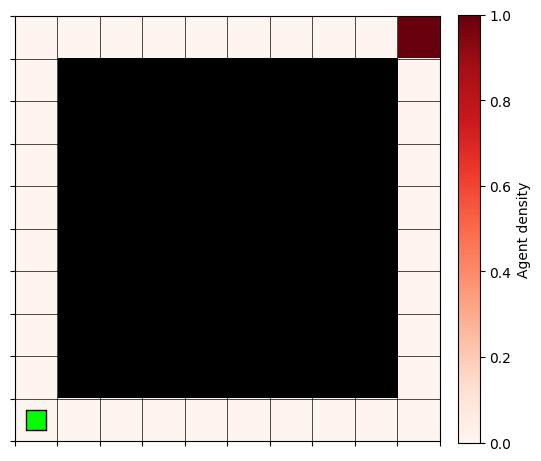


Step 1:
Actions: {'movement_agent_0': np.int64(0), 'movement_agent_1': np.int64(2), 'movement_agent_2': np.int64(1), 'movement_agent_3': np.int64(2), 'movement_agent_4': np.int64(3)}
{'movement_agent_0': array([0.9, 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
      dtype=float32), 'movement_agent_1': array([0.9, 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 

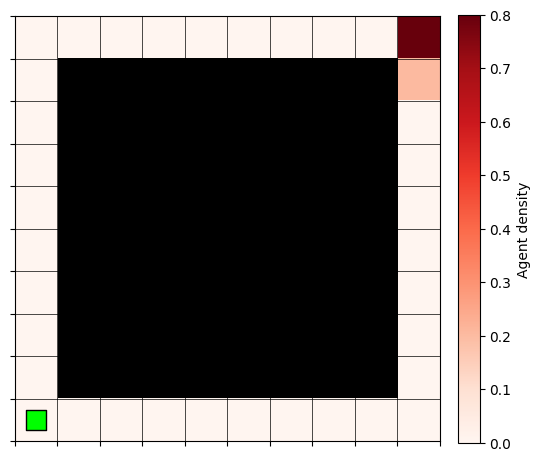


Step 2:
Actions: {'movement_agent_0': np.int64(2), 'movement_agent_1': np.int64(2), 'movement_agent_2': np.int64(0), 'movement_agent_3': np.int64(4), 'movement_agent_4': np.int64(1)}
{'movement_agent_0': array([0.8, 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.8],
      dtype=float32), 'movement_agent_1': array([0.9, 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 

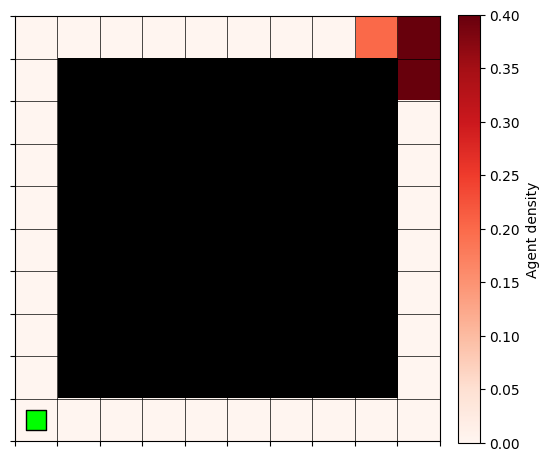


Step 3:
Actions: {'movement_agent_0': np.int64(2), 'movement_agent_1': np.int64(1), 'movement_agent_2': np.int64(4), 'movement_agent_3': np.int64(4), 'movement_agent_4': np.int64(0)}
{'movement_agent_0': array([0.8, 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0.4, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.4],
      dtype=float32), 'movement_agent_1': array([0.9, 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 

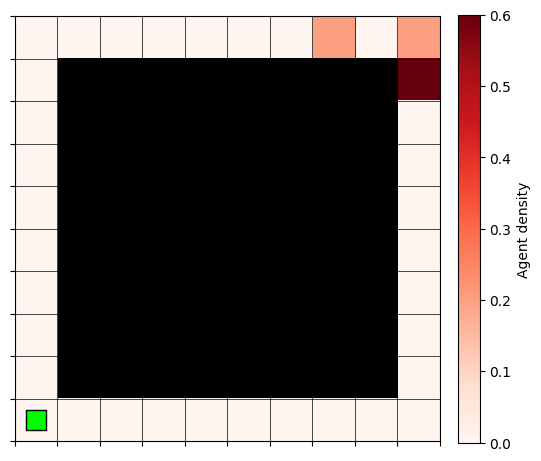

In [560]:
# Test the environment with random actions
obstacles_test = [(x, y) for x in range(1, 9) for y in range(1, 9)]
env = MyCustomEnv2(size=(10, 10), num_moving_agents = 5, obstacles = obstacles_test)  # Start with fewer agents for testing
obs, info = env.reset()

print("Initial state:")
print(f"Agent positions: {env.positions}")
print(f"Mean field shape: {env.mean_field.shape}")
print(f"Observation keys: {list(obs.keys())}")
print(f"First agent observation shape: {obs['movement_agent_0'].shape}")

# Render to visualize
env.render()
env.close()

# Take a few random steps
for step in range(3):
    # Generate random actions for all agents
    actions = {agent: env.action_spaces[agent].sample() for agent in env.agents}
    
    print(f"\nStep {step + 1}:")
    print(f"Actions: {actions}")

    print(obs)
    
    obs, rewards, terminations, truncations, infos = env.step(actions)
    
    print(f"New positions: {env.positions}")
    print(f"Rewards: {rewards}")
    print(f"Terminations: {terminations}")
    
    # Render to visualize
    env.render()
    env.close()

In [561]:
import torch
from tensordict.nn.sequence import TensorDictSequential
from tensordict import TensorDict
from torchrl.envs.utils import set_exploration_type, ExplorationType
from torchrl.envs import PettingZooWrapper

# Load the model with weights_only=False
policy = torch.load("trained_model.pt", weights_only=False)
policy.eval()  # Set the model to evaluation mode

TensorDictSequential(
    module=ModuleList(
      (0): ProbabilisticActor(
          module=ModuleList(
            (0): Mlp()
            (1): SafeProbabilisticModule()
          ),
          device=cpu,
          in_keys=[('movement_agent', 'observation')],
          out_keys=[('movement_agent', 'logits'), ('movement_agent', 'action'), ('movement_agent', 'log_prob')])
    ),
    device=cpu,
    in_keys=[('movement_agent', 'observation')],
    out_keys=[('movement_agent', 'logits'), ('movement_agent', 'action'), ('movement_agent', 'log_prob')])

In [562]:
# --- 1. Load the model (as you did in your notebook) ---
# Assuming 'policy' is your Mlp instance (or the TensorDictSequential wrapping it)
# Make sure you import the necessary classes (Mlp, etc.) if they weren't saved with the model.
path_to_saved_model = "trained_model.pt"
policy = torch.load(path_to_saved_model, weights_only=False)
policy.eval() # Always set to eval mode for deployment/inference

N_AGENTS = 50 # Replace with the actual number of agents in your environment
OBS_DIM = 102 # Replace with the actual dimension of a single agent's observation

In [563]:
raw_env = MyCustomEnv2()

# 2. Define the agent grouping map for the TorchRL wrapper
# This map tells the wrapper which raw agent names belong to which group name 
# ('movement_agent' in your case).
# You need to dynamically generate the list of agents from your environment:
agent_names = raw_env.possible_agents
agent_group_map = {'movement_agent': agent_names}

# 3. Create the TorchRL environment instance
env = PettingZooWrapper(
            MyCustomEnv2(),
            categorical_actions=True,
            device="cpu",
            return_state=False
        )

c:\Uzh\thesis\thesisenv311\Lib\site-packages\torchrl\envs\libs\pettingzoo.py:282: UserWarning: PettingZoo in TorchRL is tested using version == 1.24.3 , If you are using a different version and are experiencing compatibility issues,please raise an issue in the TorchRL github.
  warnings.warn(
c:\Uzh\thesis\thesisenv311\Lib\site-packages\pettingzoo\utils\env.py:370: UserWarning: Your environment should override the action_space function. Attempting to use the action_spaces dict attribute.
  warnings.warn(
c:\Uzh\thesis\thesisenv311\Lib\site-packages\pettingzoo\utils\env.py:358: UserWarning: Your environment should override the observation_space function. Attempting to use the observation_spaces dict attribute.
  warnings.warn(


In [564]:
# 4. Reset the environment to get the initial TensorDict of observations
# This TensorDict contains the actual initial observations from the environment.
env_td = env.reset()


# Verify the observation key and shape:
# The shape should be (N_AGENTS, OBS_DIM) inside the TensorDict at this key
print("\n--- Environment Reset Successful ---")
print(f"Observation Key: {('movement_agent', 'observation')}")
print(f"Observation Tensor Shape: {env_td}")


--- Environment Reset Successful ---
Observation Key: ('movement_agent', 'observation')
Observation Tensor Shape: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        movement_agent: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([50, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                observation: Tensor(shape=torch.Size([50, 102]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([50, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([50, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([50]),
            device=cpu,
            is_shared=False),
        terminated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool, is_shared=False),
        truncated: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.bool,

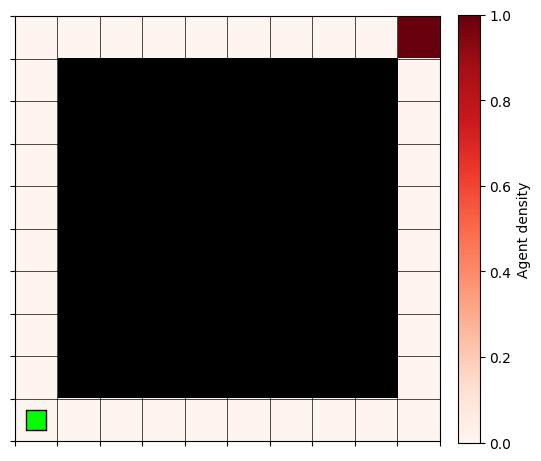


--- Action Tensor ---
tensor(4)
Shape: torch.Size([50])

--- Logits Tensor ---
tensor([ 6.0207, -7.1949, -1.2912, -6.6100,  9.0551])
Shape: torch.Size([50, 5])
tensor([[0.9000, 0.9000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.9000, 0.9000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.9000, 0.9000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        ...,
        [0.9000, 0.9000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.9000, 0.9000, 0.0000,  ..., 0.0000, 0.0000, 1.0000],
        [0.9000, 0.9000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])


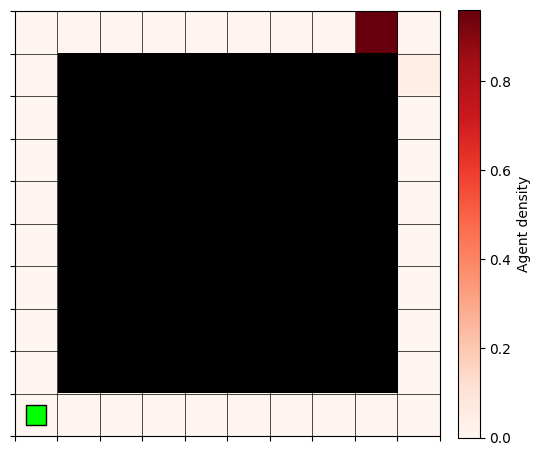


--- Environment Step Successful ---
New Observation Tensor Shape: torch.Size([50, 102])


In [565]:
from torchrl.envs.utils import set_exploration_type, ExplorationType

env.render()
env.close()

# 5. Use the policy to calculate the action based on the real observation
with torch.no_grad(), set_exploration_type(ExplorationType.RANDOM):
    # Pass the TensorDict containing the real observation
    action_td = policy(env_td)

# Assuming 'action_td' is available from the model's forward pass
# e.g., action_td = policy(env_td)

# A. The Action Tensor (what you pass to env.step())
action_tensor = action_td.get(('movement_agent', 'action'))
print("\n--- Action Tensor ---")
print(action_tensor[0])
print(f"Shape: {action_tensor.shape}")
# Shape will typically be [N_AGENTS, 1] or [N_AGENTS, Action_Dimension]

# B. The Logits Tensor (used to determine the most likely action)
logits_tensor = action_td.get(('movement_agent', 'logits'))
print("\n--- Logits Tensor ---")
print(logits_tensor[0])
print(f"Shape: {logits_tensor.shape}")
# Shape will typically be [N_AGENTS, N_DISCRETE_ACTIONS]


# 6. Step the environment with the calculated action
# This returns the TensorDict for the *next* time step, which includes:
# - new observations (under key: ('movement_agent', 'observation'))
# - rewards, done flags, etc.
next_env_td = env.step(action_td)
print(next_env_td.get(('movement_agent', 'observation')))

env.render()
env.close()

# 7. Check the new observation data
print("\n--- Environment Step Successful ---")
print(f"New Observation Tensor Shape: {env_td.get(('movement_agent', 'observation')).shape}")